###### 0. Read Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import random
from boto.s3.connection import S3Connection
from boto.s3.key import Key
from scipy.sparse.csr import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from math import ceil
from itertools import product
%matplotlib inline

###### 1. Setting global variables

In [2]:
'''switches'''
park_info_from_S3 = False # read park info table True: read from S3, False: read from local
review_from_S3 = False # read review table True: read from S3, False: read from local
FIT_SWITCH = False # True: grid search, fitting data False: read fitted model from local
SAVE_SWTICH = False # True: save the cluster assignment and feature extracted to local

'''amazon S3'''
ACCESS_KEY = "" # S3 access key
SECRET_KEY = "" #s3 secret key
BUCKET_NAME = 'parks101' #s3 bucket name

'''file path and file name'''
DATA_FOLDER = '/Users/Wei.Zhao/Documents/Python code/tripadvisor/'
MODEL_FOLDER = '/Users/Wei.Zhao/Documents/Python code/tripadvisor/models/'
PARK_INFO_S3 = 'park_info_clean.csv'
#PARK_INFO_local='parks_info.csv'
#REVIEW_RAW_FILE = 'Reviews_raw.csv'
CLEAN_PARK_INFO_FILE = 'parks_info_final.csv'
CLEAN_REVIEW_FILE = 'reviews_clean.csv'


###### 2. Read Data from saved cleaned dataframes.
* Does not use pyspark due to community edition speed limitation

In [3]:
'''read in park info table'''
review_df_columns = ['index', 'comments', 'date', 'park_id', 'stars', 'title', 'reviewer_level', 'reviewer']
review_df_dtypes = {'index': np.int32, 
                    'comments': np.object, 
                    'date': str, 
                    'park_id': np.int32, 
                    'stars': np.int32, 
                    'title': str, 
                    'reviewer_level': np.int32, 
                    'reviewer': str}
if park_info_from_S3:
    s3_handle = S3Connection(ACCESS_KEY, SECRET_KEY)
    bucket_handle = s3_handle.get_bucket(BUCKET_NAME)
    file_handle = Key(bucket_handle)
    file_handle.key = PARK_INFO_S3
    file_handle.open()
    parks_info_df = pd.read_csv(file_handle, index_col=0)
    file_handle.close()
    parks_df.to_csv(os.path.join(DATA_FOLDER,os.path.join(DATA_FOLDER,CLEAN_PARK_INFO_FILE)))
else:
    parks_df = pd.read_csv(os.path.join(DATA_FOLDER, CLEAN_PARK_INFO_FILE), index_col=0)
    
'''read in review table'''
if review_from_S3: 
    file_handle.key = REVIEW_RAW_FILE
    file_handle.open()
    review_raw_df = pd.read_csv(file_handle, index_col=0, header=0)
    file_handle.close()
else:
    review_df = pd.read_csv(os.path.join(DATA_FOLDER, CLEAN_REVIEW_FILE), index_col=0)

In [4]:
parks_df.head(2)

,park_id,html,name,city,state,Excellent,Very_good,Average,Poor,Terrible,...,Couples,Friends,Solo,Business,Spring,Summer,Fall,Winter,total_visit,state_abb
0,0.0,https://www.tripadvisor.com/Attraction_Review-...,Central Park,New_York_City_New,New York,35444.0,9112.0,1380.0,132.0,52.0,...,15311.0,7739.0,2824.0,1144.0,11247.0,14390.0,11419.0,9064.0,46120.0,NY
1,1.0,https://www.tripadvisor.com/Attraction_Review-...,Hot Springs National Park,Hot_Springs,Arkansas,210.0,99.0,42.0,13.0,5.0,...,151.0,46.0,15.0,6.0,104.0,143.0,78.0,44.0,369.0,AR


In [5]:
review_df.head(2)

,park_id,review_index,reviewer,reviewer_level,date,stars,title,comments
0,759,0,podrozniczka60,6,2015-09-26,3,helpful with your utah vacation planning,helpful with your utah vacation planning uta...
1,759,1,prpatel007,1,2013-10-14,5,shame on us americans,shame on us americans recently i and my wife...


###### 3. Processing review data for modeling
* 3.1 Concatenate reviews for the same park 
* 3.2 Joint two dataframes for combined comments and visit type information

In [6]:
def concat(df):
    return pd.Series(dict(park_id=int(df['park_id'].mean()),
                          stars=df['stars'].mean(),
                          comments=' '.join(df['comments'])))
    
review_grouped_df = review_df.groupby('park_id',as_index=False).apply(concat)

merge_col = ['park_id', 'name', 'state','Families', 'Couples', 'Friends', 'Solo', 'Business', 'Spring',
             'Summer', 'Fall', 'Winter','total_visit']
park_groups_df = pd.merge(review_grouped_df, parks_df[merge_col], on='park_id')
park_groups_df.head(2)

,comments,park_id,stars,name,state,Families,Couples,Friends,Solo,Business,Spring,Summer,Fall,Winter,total_visit
0,great place to see what39s going on in nyc g...,0,4.730393,Central Park,New York,12377.0,15311.0,7739.0,2824.0,1144.0,11247.0,14390.0,11419.0,9064.0,46120.0
1,well worth our time beautiful drive and we h...,1,4.350000,Hot Springs National Park,Arkansas,95.0,151.0,46.0,15.0,6.0,104.0,143.0,78.0,44.0,369.0


###### 4. Sentiment analysis with KMeans
* clustering parks based on the aggregated comments

* 4.1 Build Pipeline
* 4.2 Build parameter optimization grid

In [6]:
pipeline = Pipeline([('vect', TfidfVectorizer(strip_accents='unicode',
                                              max_df = 0.5,
                                              token_pattern = r'\b\w+\b',
                                              ngram_range=(1,1), 
                                              stop_words='english')),
                     ('svd', TruncatedSVD()),
                     ('norm', Normalizer(copy=False)),
                     ('kmeans', KMeans())])

param_grid = {'vect__min_df': [1],
              'svd__n_components': [300,500],
              'kmeans__n_clusters': [10,15]}

search_grid = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           verbose=1,
                           refit=True)

if FIT_SWITCH:
    search_grid.fit(park_groups_df['comments'])
    best_estimator = search_grid.best_estimator_

* 4.3 Save the best model or load fitted model from local

In [8]:
model_file_name = '/Users/Wei.Zhao/Documents/Python code/tripadvisor/models/kmeans_model_simple2.pkl'
grid_file_name = '/Users/Wei.Zhao/Documents/Python code/tripadvisor/models/kmeans_grid_simple2.pkl'
if FIT_SWITCH:
    joblib.dump(search_grid.best_estimator_, model_file_name)
    joblib.dump(search_grid.grid_scores_, grid_file_name)
    best_estimator = search_grid.best_estimator_
    grid_score = search_grid.grid_scores_
else:
    best_estimator = joblib.load(model_file_name)
    grid_score = joblib.load(grid_file_name)
    
fitted_vects = best_estimator.named_steps['vect'].transform(park_groups_df['comments']) #tfidf sparse matrix
fitted_svds = best_estimator.named_steps['svd'].transform(fitted_vects) #reduced dimension of tfidf

In [10]:
'''get cluster assignments'''
cluster_assignment = best_estimator.named_steps['kmeans'].labels_
variance_explained=best_estimator.named_steps['svd'].explained_variance_ratio_.sum()
print 'variance_explained is %f.' %variance_explained

variance_explained is 0.737828.


###### 5. Visualization of clusters
* 5.1 parks clusters
* 5.2 key words in clusters

* 5.1.1 reduce to 3d space
* 5.1.2 plot park clusters in 3d 

In [11]:
reduce_model = TSNE(n_components=3, random_state=0)
pos = reduce_model.fit_transform(fitted_svds) 

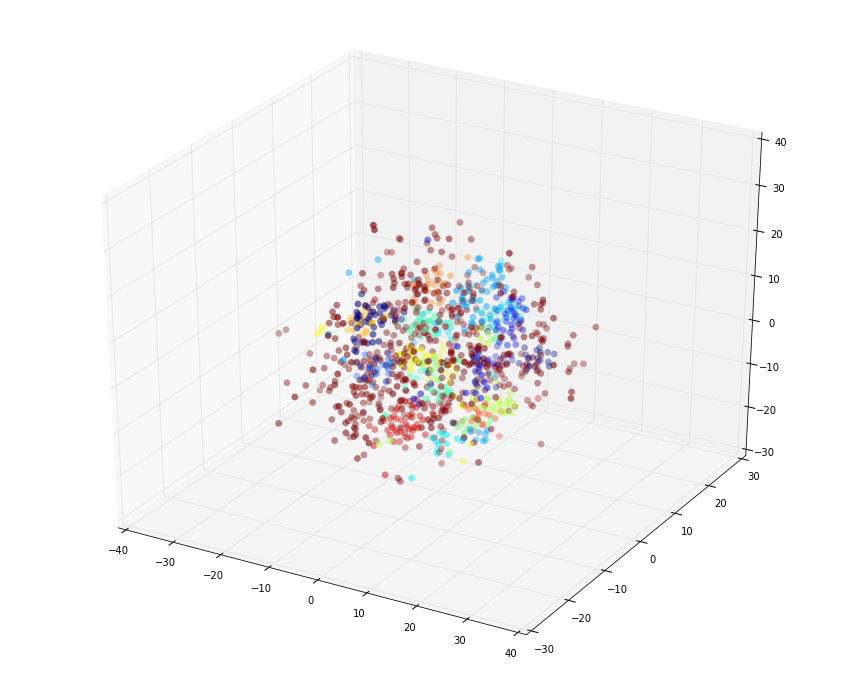

In [16]:
cluster_n = len(set(cluster_assignment)) # number of clusters
def plot_projection(data, cluster_assignments, cluster_n):
    alpha = 0.7
    size = 15
    fig = plt.figure(figsize=(size, size * 0.8))
    ax = fig.add_subplot(111, projection='3d')
    xpos, ypos, zpos = zip(*data[:, 0:3])
    color_list = [plt.get_cmap('jet')(int(i)) for i in np.linspace(0, 256, cluster_n)]
    color_list = random.sample(color_list, len(color_list))
    colors = [color_list[i] * np.array([1, 1, 1, alpha]) for i in cluster_assignments]
    ax.scatter(xpos, ypos, zpos, marker='o', c=colors, s=size*3, linewidth=0)

plot_projection(pos, cluster_assignments, cluster_n)


* 5.2.1 Extract clustering keywords

In [12]:
cluster_centers = best_estimator.named_steps['kmeans'].cluster_centers_
original_space_centroids = best_estimator.named_steps['svd'].inverse_transform(cluster_centers)
order_centroids = original_space_centroids.argsort()[:,::-1]
feature_words = best_estimator.named_steps['vect'].get_feature_names()
feature_dict = dict()
words_n = 30 # get top 30 words
for i, cluster in enumerate(original_space_centroids):
    feature_dict[i] = [feature_words[j] for (count, j) in enumerate(order_centroids[i]) if count < words_n]    

* 5.2.2 Visualization keywords clustering

/Users/Wei.Zhao/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


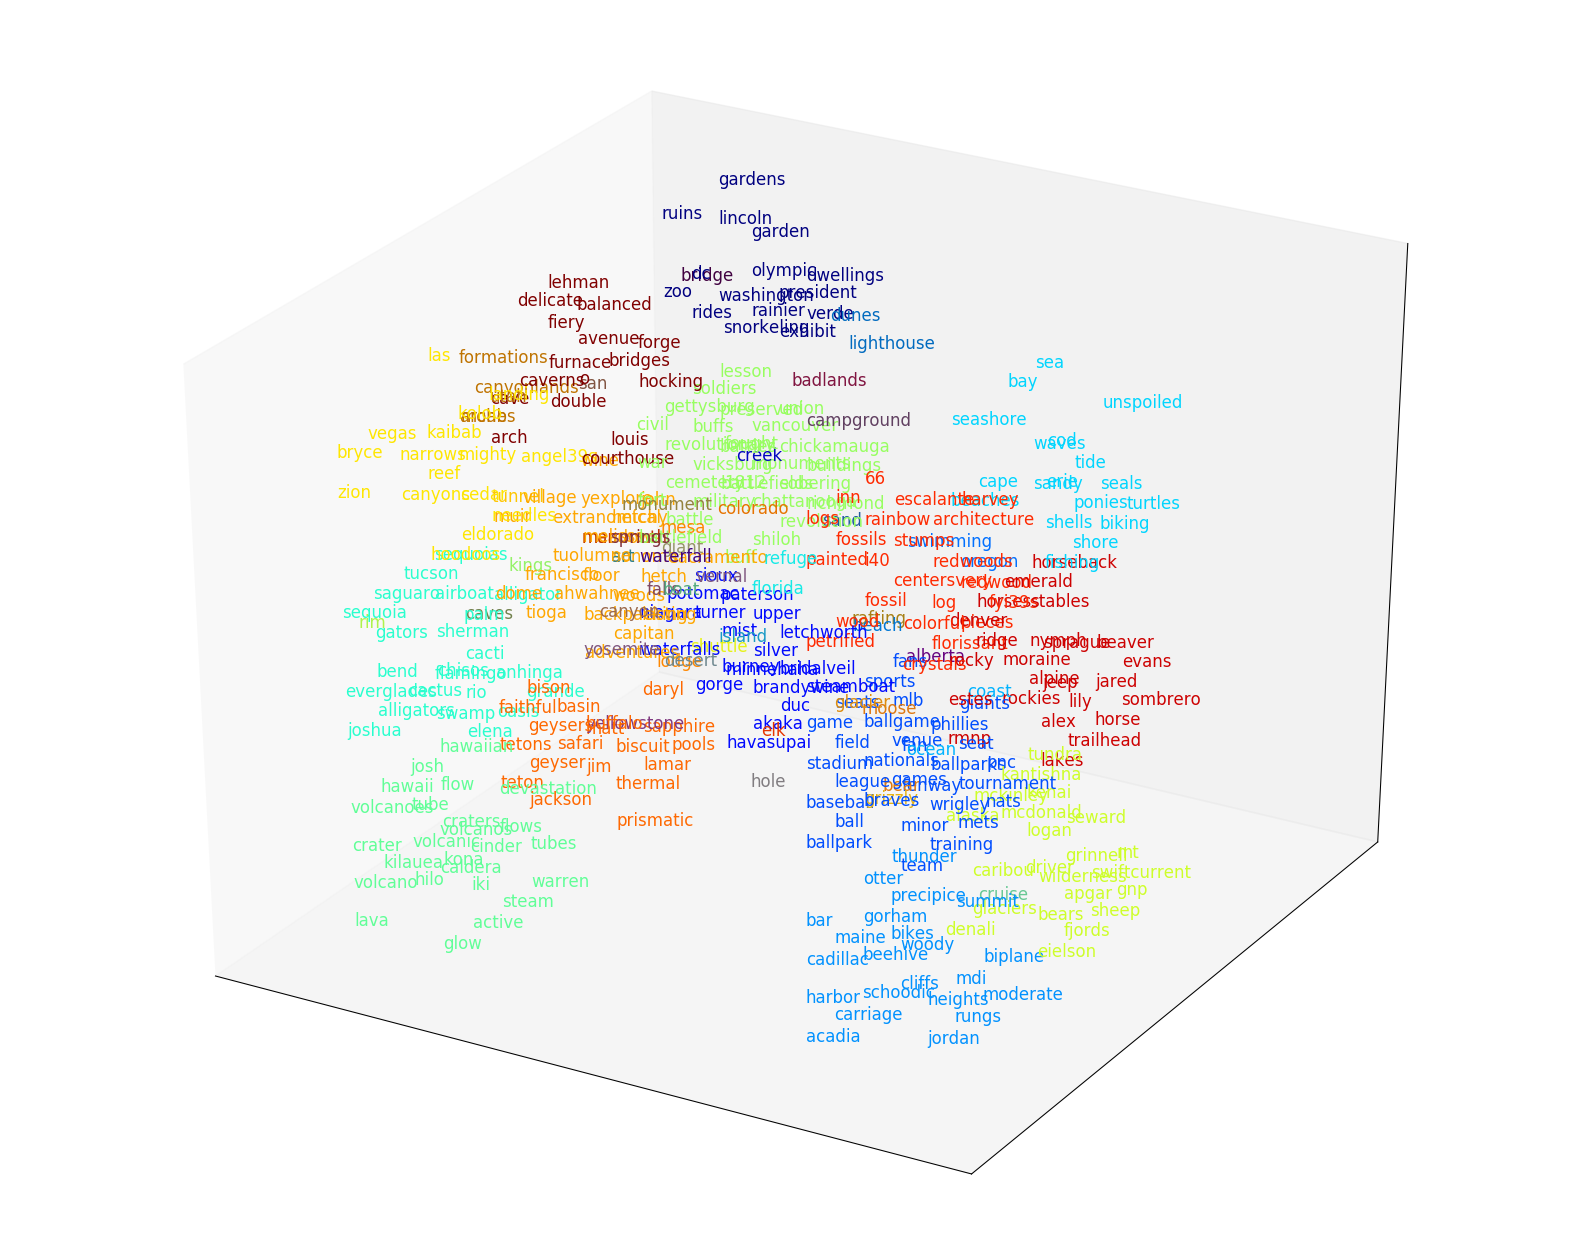

In [13]:
def cluster_radius(cluster):
    '''calculate the radius of one cluster'''
    max_r = max([len(v) for (k, v) in cluster.items()])
    return int(ceil(max_r ** (1/3.0)))

def assign_cords(points, origin=np.zeros(3), radius=1):
    '''calculate'''
    l = len(points)
    d = int(ceil(l ** (1/3.0)))
    pos = zip([i + origin for i in product(np.array(range(d)) * radius, repeat=3)], points)
    return [pos[int(i)] for i in np.linspace(0, len(pos)-1, l)]

def assign_colors(clusters):
    if isinstance(clusters, (int, float)):
        l = int(clusters)
    else:
        l = len(clusters) + 1
    color_list = [plt.get_cmap('jet')(int(i)) for i in np.linspace(0, 256, l)]
    return random.sample(color_list, len(color_list))

def cluster_cords(clusters):
    cluster_r = cluster_radius(clusters) + 1
    cords = dict()
    cluster_centers = assign_cords(clusters.keys(), np.zeros(3), cluster_r)
    colors = assign_colors(clusters)
    for (cluster_name, one_cluster, one_center, onecolor) in zip(clusters.keys(), clusters.values(), cluster_centers, colors):
        cluster_cords = [(i[1], i[0], onecolor) for i in assign_cords(one_cluster, one_center[0], 1)]
        cords[cluster_name] = cluster_cords
    return cords


def adjust_cords(cords):
    cal_cords = {}
    new_cords = {}
    for one_cluster in cords.values():
        for one_point in one_cluster:
            try:
                cal_cords[one_point[0]].append((one_point[1], one_point[2]))
            except KeyError:
                cal_cords[one_point[0]] = [(one_point[1], one_point[2])]
   
    for point_key, one_point in cal_cords.items():
        new_point = zip(*one_point)
        new_cord = np.mean(np.vstack(new_point[0]), axis=0)
        new_color = np.mean(np.vstack(new_point[1]), axis=0)
        new_cords[point_key] = (new_cord, new_color)
    return new_cords


def draw_cords(cords):
    size = 20
    plot_range = np.max(np.vstack([i[0] for i in cords.values()]), axis=0) + np.ones(3)
    fig = plt.figure(figsize=(size, size * 0.8))
    ax = fig.add_subplot(111, projection='3d')
    for one_key, one_point in cords.items():
        ax.text(one_point[0][0], one_point[0][1], one_point[0][2] , one_key, color=one_point[1], size=size*0.6)
        #ax.scatter(one_point[0][0], one_point[0][1], one_point[0][2] , one_key, color=one_point[1])
    ax.set_xlim([-1, plot_range[0]])
    ax.set_ylim([-1, plot_range[1]])
    ax.set_zlim([-1, plot_range[2]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    fig.show()


test_cords = cluster_cords(feature_dict)
#print 'test_cords', test_cords
new_cords = adjust_cords(test_cords)
#print 'new_cords',new_cords
draw_cords(new_cords)

###### 6 Query similar parks 
* 6.1 Retrieve cluster members
* 6.1.1 Find words with top 30 tf-idf score for each park

In [14]:
park_groups_df['cluster_assignment'] = pd.Series(cluster_assignment, index=park_groups_df.index)
park_groups_df['cluster_assignment'].value_counts()

8     497
2     73 
1     65 
7     63 
3     44 
14    42 
12    38 
5     35 
0     34 
6     30 
13    29 
9     25 
10    20 
4     19 
11    11 
Name: cluster_assignment, dtype: int64

In [16]:
vocabulary = best_estimator.named_steps['vect'].get_feature_names()
park_features=[]
for ind in park_groups_df.index:
    park_x = fitted_vects[ind]
    park_features.append([y[0] for y in sorted(zip(vocabulary, park_x.todense().A1), 
                                               key=lambda x:x[1],reverse=True)[0:20]])
park_groups_df['park_features']= pd.Series(park_features,index=park_groups_df.index)



park_assignment_df = park_groups_df[['park_id','cluster_assignment','park_features']]

In [78]:
'''save the result to csv'''
if SAVE_SWITCH == True:
    park_assignment_df = park_groups_df[['park_id','cluster_assignment','park_features']]
    park_assignment_df.to_csv(os.path.join(DATA_FOLDER,'park_assignment.csv'))

* 6.1.2 Retrieve parks using cluster label

In [25]:
pd.set_option('display.max_colwidth',-1)
query_cluster = 2
season = 'Winter'
visit_type = 'Families'
cluster_name = 'cluster'+'_'+str(query_cluster)
cluster_name = (park_groups_df[park_groups_df['cluster_assignment']==query_cluster]
                .sort_values([season,'stars','total_visit',visit_type],ascending=False)
               [['park_id','name','state','stars',season,visit_type,'total_visit','park_features','cluster_assignment']])
cluster_name.head(2)

,park_id,name,state,stars,Winter,Families,total_visit,park_features,cluster_assignment
42,42,Red Rock Canyon National Conservation Area,Nevada,4.735837,2963.0,2577.0,13359.0,"[vegas, canyon, strip, las, desert, formations, calico, casinos, conservation, burros, lv, 13mile, helicopter, climbers, casino, canyons, rented, glitz, hustle, escape]",2
8,8,Grand Canyon National Park,Arizona,4.855217,1064.0,1902.0,7417.0,"[canyon, rim, vegas, helicopter, las, shuttle, angel, justice, bucket, buses, sunrise, gc, skywalk, bright, mather, flagstaff, hoover, kaibab, tovar, lodge]",2


* 6.1.3 Query similar parks

In [19]:
the_park = park_groups_df[park_groups_df['name'].str.contains("Magic Kingdom")][['park_id','name','state','total_visit','cluster_assignment','park_features']]
the_park

,park_id,name,state,total_visit,cluster_assignment,park_features
39,39,Magic Kingdom,Florida,26005.0,8,"[kingdom, magic, disney, rides, fireworks, parade, castle, parades, lines, characters, mk, fastpass, orlando, fantasyland, passes, mickey, happiest, christmas, theme, princesses]"


In [24]:
pd.set_option('display.max_colwidth',-1)
query_cluster =park_groups_df.loc[the_park['park_id']]['cluster_assignment']
season = 'Winter'
visit_type = 'Families'
cluster_name = 'cluster'+'_'+str(query_cluster)
cluster_name = (park_groups_df[park_groups_df['cluster_assignment']==query_cluster.values[0]]
                .sort_values([season,'stars','total_visit',visit_type],ascending=False)
               [['park_id','name','state','stars',season,visit_type,'total_visit','park_features']])
cluster_name.head(2)


,park_id,name,state,stars,Winter,Families,total_visit,park_features
0,0,Central Park,New York,4.730393,9064.0,12377.0,46120.0,"[central, nyc, york, carriage, strawberry, horse, zoo, lennon, manhattan, oasis, skating, boathouse, ny, fields, bikes, rink, bustle, hustle, belvedere, bethesda]"
879,896,Top of the Rock Observation Deck,New York,4.666469,7022.0,8699.0,32569.0,"[empire, nyc, york, manhattan, central, esb, observation, rockefeller, deck, tickets, elevator, queues, skyline, queue, ny, ticket, lift, totr, lines, glass]"
